In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import joblib

from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from skimage.io import imread
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, Model
from keras.losses import binary_crossentropy
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import ResNet50, ResNet50V2, VGG16
from keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator

##  Mounting Google Drive and Loading the Dataset:

The dataset is stored in our Google Drive so first we have to connect our Google Drive to the working environment

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the directory containing the dataset
directory_path = '/content/drive/MyDrive/green_guardian/'

# Data Preprocessing

## Getting Filepaths and Labels:

This code searches for jpg and files recursively within the directory_path using image_dir.glob.

It then extracts the class label from the path using os.path.split and map.

The filepaths and labels are converted to Pandas Series (one-dimensional arrays) and named appropriately.

Finally, they are concatenated into a DataFrame image_df for easier manipulation.

Before you can use the images for machine learning, you need organized information about them. This code snippet:
Finds all image files within your specified directory.

Extracts the important class label (like "Paper" or "Plastic") from the file's directory structure

Creates an organized data structure (a DataFrame) to easily manage both the image locations and their corresponding labels.

In [ ]:
image_dir = Path(directory_path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath    Label
0     /content/drive/MyDrive/green_guardian/Paper/00...    Paper
1     /content/drive/MyDrive/green_guardian/Paper/00...    Paper
2     /content/drive/MyDrive/green_guardian/Paper/00...    Paper
3     /content/drive/MyDrive/green_guardian/Paper/00...    Paper
4     /content/drive/MyDrive/green_guardian/Paper/00...    Paper
...                                                 ...      ...
9995  /content/drive/MyDrive/green_guardian/Plastic/...  Plastic
9996  /content/drive/MyDrive/green_guardian/Plastic/...  Plastic
9997  /content/drive/MyDrive/green_guardian/Plastic/...  Plastic
9998  /content/drive/MyDrive/green_guardian/Plastic/...  Plastic
9999  /content/drive/MyDrive/green_guardian/Plastic/...  Plastic

[10000 rows x 2 columns]

## Visualizing Random Image Samples:

[4934 3980 2483 5033 5576 7928 2853 4927 4085 8533 3750 3087 5046 4034
 8222 5814]


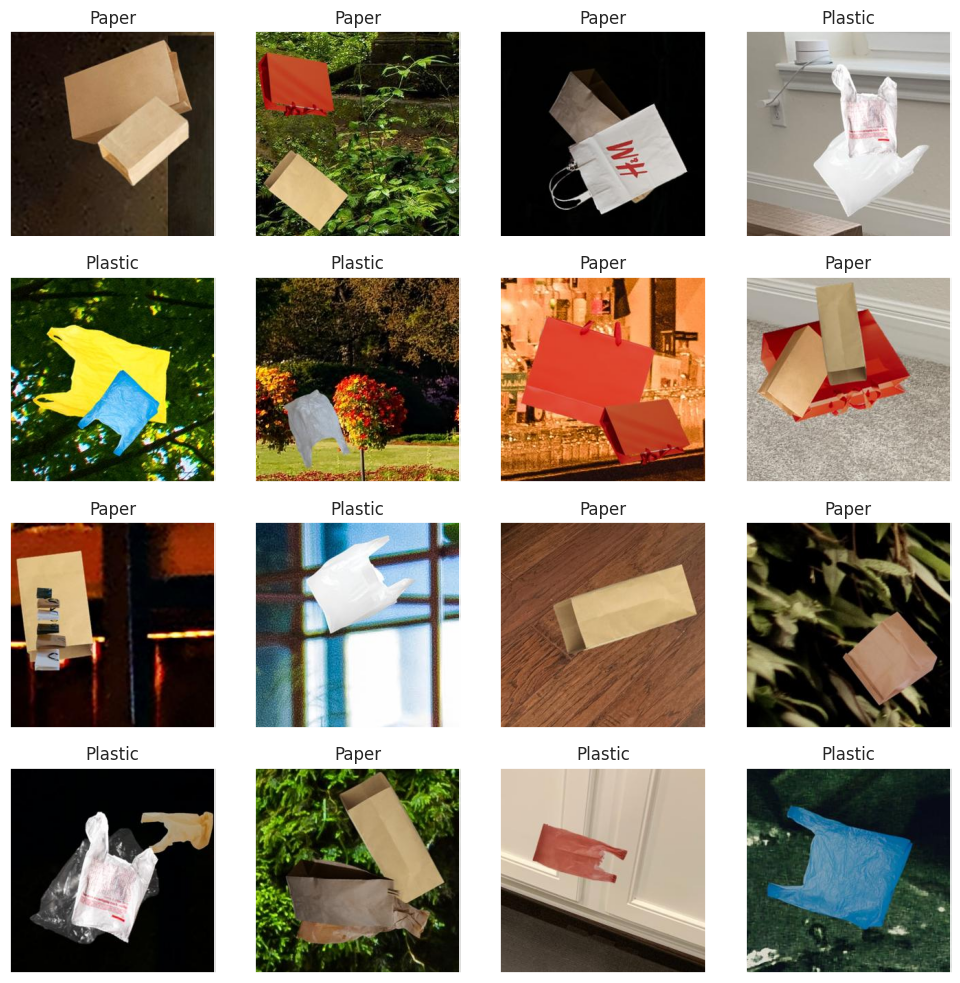

In [ ]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Loading and Preprocessing Images:

The machine learning model can't understand images directly. So we need to make the images suitable for the model by:

Loading images: Reading image data into a format you can manipulate.

Resizing: Ensuring all images have the same size for consistency in your model.

Normalizing: Bringing pixel values into a standard range (usually 0-1) to help the model learn efficiently.

Flattening: convert the 2D image data into a 1D array.

In [ ]:
def load_and_preprocess_image(filepath):
    image = imread(filepath)
    image = resize(image, (256, 256))
    image = image.astype('float32') / 255.0  # Normalize pixel values
    return image.flatten()  # Flatten for SVM input

In [ ]:
# Load and preprocess images into a NumPy array
images = np.stack(image_df['Filepath'].apply(load_and_preprocess_image))

## Train-Test Split:

To split the dataset into training and testing sets, we utilized scikit-learn's train_test_split function. This code ensures that 30% of the data will be allocated for testing, while 70% will be utilized for training purposes.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(images, image_df['Label'], test_size=0.3, random_state=42)

In [ ]:
# Check shapes after splitting
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a technique used for dimensionality reduction and feature extraction. It works by transforming the original features into a new set of orthogonal features called principal components. The principal components are ordered in such a way that the first component explains the maximum variance in the data, the second component explains the second most variance, and so on.

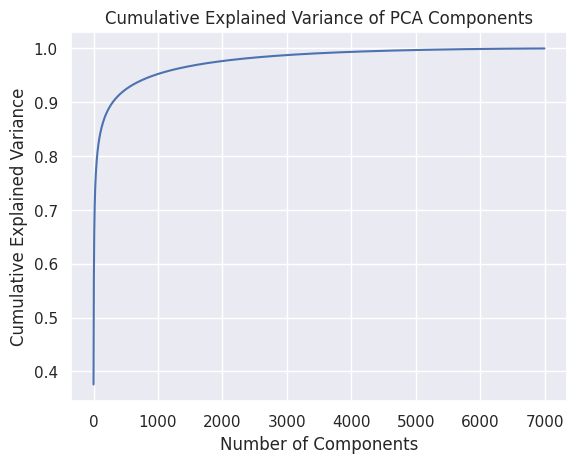

In [ ]:
pcad = PCA()
pcad.fit(X_train)
cumulative_explained_variance = np.cumsum(pcad.explained_variance_ratio_)

plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance of PCA Components')
plt.show()

 The slope of the line indicates how quickly the variance is explained. A steeper slope at the beginning suggests that the first few components are more informative, while a flatter curve towards the end suggests that subsequent components contribute less to explaining the variance.

The first few principal components capture a significant portion of the variance in the data. This is because the curve increases rapidly at the beginning, indicating that the initial components effectively capture the underlying structure of the data.
Adding more components after a certain point likely contributes less to explaining the variance. The slope flattens out towards the end, suggesting that the remaining variance is likely due to noise or unimportant variations in the data. Including additional components in this region might not be very informative, as they might primarily capture noise rather than the core structure of the data.

The StandardScaler is used for standardizing the features.
PCA is used for principal component analysis, with 150 components, whitening enabled, and a specific random state for reproducibility. These steps are often used together in pipelines for machine learning tasks to ensure that the data is properly scaled and reduced in dimensionality before applying models.

In [ ]:
scaler = StandardScaler()
pca = PCA(n_components=150, whiten=True, random_state=42)

# SVM Models

## First Trial

###  RBF SVM with Grid Search

the code below sets up a pipeline consisting of data preprocessing steps (scaling and PCA) followed by an SVM model with an RBF kernel. It then defines a grid of hyperparameters for the SVM model and uses GridSearchCV to search for the best combination of hyperparameters based on cross-validated performance. This approach helps to optimize the model's performance and generalize well to unseen data.

In [ ]:
rbf_model = make_pipeline(scaler, pca, SVC(kernel='rbf'))

In [ ]:
rbf_param_grid = {'svc__C': [2, 3, 4], 'svc__gamma': [0.005]}

In [ ]:
grid_rbf = GridSearchCV(rbf_model, rbf_param_grid, cv=5, verbose=2)

In [ ]:
grid_rbf.fit(X_train, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .........................svc__C=2, svc__gamma=0.005; total time= 1.6min
[CV] END .........................svc__C=2, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=2, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=2, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=2, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=3, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=3, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=3, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=3, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=3, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=4, svc__gamma=0.005; total time= 1.5min
[CV] END .........................svc__C=4, svc__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [2, 3, 4], 'svc__gamma': [0.005]},
             verbose=2)

In [ ]:
print(f'Best parameters are: {grid_rbf.best_params_}')
mean_score = grid_rbf.cv_results_['mean_test_score']
std_score = grid_rbf.cv_results_['std_test_score']
params = grid_rbf.cv_results_['params']
for mean,std,params in zip(mean_score,std_score,params):
      print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')

Best parameters are: {'svc__C': 4, 'svc__gamma': 0.005}
0.81 + or -0.01 for the {'svc__C': 2, 'svc__gamma': 0.005}
0.82 + or -0.01 for the {'svc__C': 3, 'svc__gamma': 0.005}
0.82 + or -0.01 for the {'svc__C': 4, 'svc__gamma': 0.005}


**Best parameters are: svc__C= 4, svc__gamma= 0.005**

In [ ]:
print("RBF Kernel:")
print("Best parameters:", grid_rbf.best_params_)
y_pred_rbf = grid_rbf.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred_rbf))
print(classification_report(Y_test, y_pred_rbf))
print(confusion_matrix(Y_test, y_pred_rbf))

RBF Kernel:
Best parameters: {'svc__C': 4, 'svc__gamma': 0.005}
Accuracy: 0.8146666666666667
              precision    recall  f1-score   support

       Paper       0.80      0.83      0.81      1463
     Plastic       0.83      0.80      0.82      1537

    accuracy                           0.81      3000
   macro avg       0.82      0.82      0.81      3000
weighted avg       0.82      0.81      0.81      3000

[[1219  244]
 [ 312 1225]]


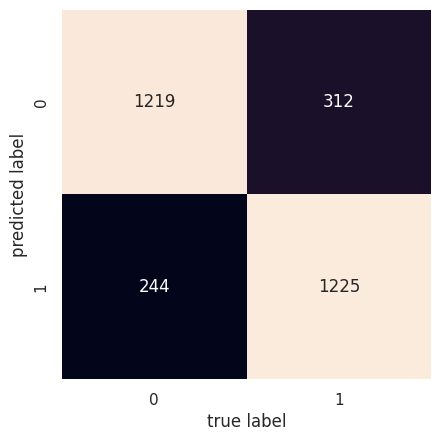

In [ ]:
mat = confusion_matrix(Y_test, y_pred_rbf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

###  Poly SVM with Grid Search

the code below sets up a pipeline consisting of data preprocessing steps (scaling and PCA) followed by an SVM model with an poly kernel. It then defines a grid of hyperparameters for the SVM model and uses GridSearchCV to search for the best combination of hyperparameters based on cross-validated performance. This approach helps to optimize the model's performance and generalize well to unseen data.

In [ ]:
poly_model = make_pipeline(scaler, pca, SVC(kernel='poly'))

In [ ]:
poly_param_grid = {'svc__C': [3, 5, 10], 'svc__degree': [1, 3, 5]}

In [ ]:
grid_poly = GridSearchCV(poly_model, poly_param_grid, cv=5, verbose=2)

In [ ]:
grid_poly.fit(X_train, Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ............................svc__C=3, svc__degree=1; total time= 1.6min
[CV] END ............................svc__C=3, svc__degree=1; total time= 1.5min
[CV] END ............................svc__C=3, svc__degree=1; total time= 1.5min
[CV] END ............................svc__C=3, svc__degree=1; total time= 1.5min
[CV] END ............................svc__C=3, svc__degree=1; total time= 1.5min
[CV] END ............................svc__C=3, svc__degree=3; total time= 1.5min
[CV] END ............................svc__C=3, svc__degree=3; total time= 1.5min
[CV] END ............................svc__C=3, svc__degree=3; total time= 1.5min
[CV] END ............................svc__C=3, svc__degree=3; total time= 1.5min
[CV] END ............................svc__C=3, svc__degree=3; total time= 1.5min
[CV] END ............................svc__C=3, svc__degree=5; total time= 1.5min
[CV] END ............................svc__C=3, sv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(kernel='poly'))]),
             param_grid={'svc__C': [3, 5, 10], 'svc__degree': [1, 3, 5]},
             verbose=2)

In [ ]:
print(f'Best parameters are: {grid_poly.best_params_}')
mean_score = grid_poly.cv_results_['mean_test_score']
std_score = grid_poly.cv_results_['std_test_score']
params = grid_poly.cv_results_['params']
for mean,std,params in zip(mean_score,std_score,params):
      print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')

Best parameters are: {'svc__C': 10, 'svc__degree': 1}
0.78 + or -0.01 for the {'svc__C': 3, 'svc__degree': 1}
0.68 + or -0.01 for the {'svc__C': 3, 'svc__degree': 3}
0.51 + or -0.0 for the {'svc__C': 3, 'svc__degree': 5}
0.78 + or -0.01 for the {'svc__C': 5, 'svc__degree': 1}
0.7 + or -0.01 for the {'svc__C': 5, 'svc__degree': 3}
0.51 + or -0.0 for the {'svc__C': 5, 'svc__degree': 5}
0.79 + or -0.01 for the {'svc__C': 10, 'svc__degree': 1}
0.71 + or -0.01 for the {'svc__C': 10, 'svc__degree': 3}
0.51 + or -0.0 for the {'svc__C': 10, 'svc__degree': 5}


**Best parameters are: svc__C= 10, svc__degree= 1**

In [ ]:
print("\nPolynomial Kernel:")
print("Best parameters:", grid_poly.best_params_)
y_pred_poly = grid_poly.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred_poly))
print(classification_report(Y_test, y_pred_poly))
print(confusion_matrix(Y_test, y_pred_poly))


Polynomial Kernel:
Best parameters: {'svc__C': 10, 'svc__degree': 1}
Accuracy: 0.788
              precision    recall  f1-score   support

       Paper       0.75      0.84      0.79      1463
     Plastic       0.83      0.74      0.78      1537

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000

[[1226  237]
 [ 399 1138]]


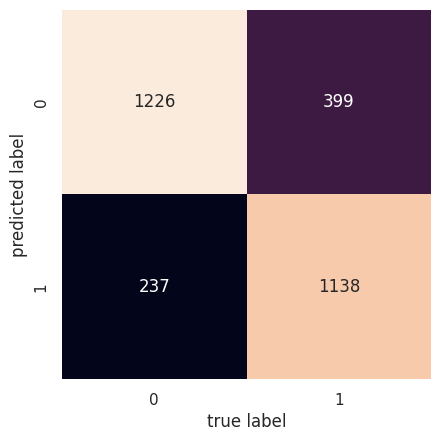

In [ ]:
mat = confusion_matrix(Y_test, y_pred_poly)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

###  Linear SVM with Grid Search

this code sets up a pipeline for preprocessing (scaling and PCA) and fitting an SVM model with a linear kernel. It then performs a grid search to find the best combination of hyperparameters for the linear kernel SVM model based on cross-validated performance.

In [ ]:
linear_model = make_pipeline(scaler, pca, SVC(kernel='linear'))

In [ ]:
linear_param_grid = {'svc__C': [0.1, 0.5, 1]}%6-6662

In [ ]:
grid_linear = GridSearchCV(linear_model, linear_param_grid, cv=5, verbose=2)

In [ ]:
grid_linear.fit(X_train, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .........................................svc__C=0.1; total time= 1.5min
[CV] END .........................................svc__C=0.1; total time= 1.5min
[CV] END .........................................svc__C=0.1; total time= 1.5min
[CV] END .........................................svc__C=0.1; total time= 1.5min
[CV] END .........................................svc__C=0.1; total time= 1.5min
[CV] END .........................................svc__C=0.5; total time= 1.6min
[CV] END .........................................svc__C=0.5; total time= 1.6min
[CV] END .........................................svc__C=0.5; total time= 1.6min
[CV] END .........................................svc__C=0.5; total time= 1.6min
[CV] END .........................................svc__C=0.5; total time= 1.6min
[CV] END ...........................................svc__C=1; total time= 1.8min
[CV] END ........................................

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(kernel='linear'))]),
             param_grid={'svc__C': [0.1, 0.5, 1]}, verbose=2)

In [ ]:
print(f'Best parameters are: {grid_linear.best_params_}')
mean_score = grid_linear.cv_results_['mean_test_score']
std_score = grid_linear.cv_results_['std_test_score']
params = grid_linear.cv_results_['params']
for mean,std,params in zip(mean_score,std_score,params):
      print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')

Best parameters are: {'svc__C': 0.5}
0.79 + or -0.01 for the {'svc__C': 0.1}
0.79 + or -0.01 for the {'svc__C': 0.5}
0.79 + or -0.01 for the {'svc__C': 1}


**Best parameter is: svc__C= 0.5**

In [ ]:
print("\nLinear Kernel:")
print("Best parameters:", grid_linear.best_params_)
y_pred_linear = grid_linear.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred_linear))
print(classification_report(Y_test, y_pred_linear))
print(confusion_matrix(Y_test, y_pred_linear))


Linear Kernel:
Best parameters: {'svc__C': 0.5}
Accuracy: 0.79
              precision    recall  f1-score   support

       Paper       0.76      0.84      0.80      1463
     Plastic       0.83      0.74      0.78      1537

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000

[[1231  232]
 [ 398 1139]]


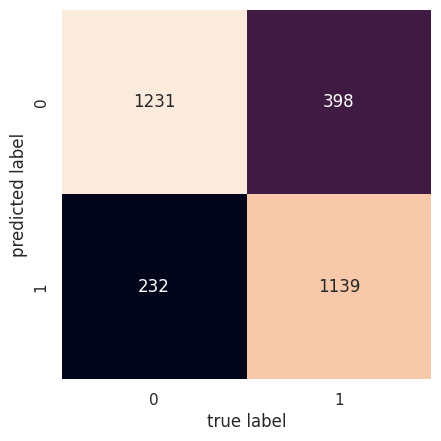

In [ ]:
mat = confusion_matrix(Y_test, y_pred_linear)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### Saving Trained SVM Models

we want to save the trained SVM models with RBF, Linear, and Polynomial kernels  using the joblib library. It specifies the file path where the model will be saved (model_file). The trained model, stored in the grid_rbf object, is dumped into the specified file using the joblib.dump() function. This allows the model to be easily retrieved and used later for making predictions on new data without needing to retrain the model.

In [ ]:
import joblib

model_file = '/content/drive/MyDrive/rbf_model.joblib'
joblib.dump(grid_rbf, model_file)

['/content/drive/MyDrive/rbf_model.joblib']

In [ ]:
model_file = '/content/drive/MyDrive/poly_model.joblib'
joblib.dump(grid_poly, model_file)

['/content/drive/MyDrive/poly_model.joblib']

In [ ]:
model_file = '/content/drive/MyDrive/linear_model.joblib'
joblib.dump(grid_linear, model_file)

['/content/drive/MyDrive/linear_model.joblib']

## Second Trial

###RBF SVM with Grid Search

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {'svc__C': [1, 5, 10],
              'svc__gamma': [0.0005, 0.001, 0.005]}

# Define PCA
pca = PCA(n_components=150, whiten=True, random_state=42)

# Define SVM with RBF kernel
svm = SVC(kernel='rbf', class_weight='balanced')

# Construct a pipeline consisting of PCA and SVM
model = make_pipeline(pca, svm)

# Perform grid search over the parameter grid
grid = GridSearchCV(model, param_grid, verbose=2)
%time grid.fit(X_train_reshaped, y_train)

# Print the best parameters found by grid search
print(f'Best parameters are: {grid.best_params_}')

# Retrieve mean and standard deviation scores for each parameter combination
mean_score = grid.cv_results_['mean_test_score']
std_score = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# Print mean and standard deviation scores for each parameter combination
for mean, std, params in zip(mean_score, std_score, params):
    print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')

# Get predictions on the test set using the best model from grid search
model = grid.best_estimator_
ypred = model.predict(X_test_reshaped)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.5min
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.1min
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.2min
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.2min
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.2min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.2min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.2min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.3min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.2min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.2min
[CV] END .........................svc__C=1, svc__gamma=0.005; total time= 1.2min
[CV] END .........................svc__C=1, svc__

**Best parameters are: svc__C= 0.5, svc__gamma': 0.005**

In [ ]:
# Accuracy and F1 scores for SVM with best RBF kernel
bestRBF_accuracy = accuracy_score(y_test, ypred)
bestRBF_f1 = f1_score(y_test, ypred, average='weighted')
print('Accuracy (Best RBF Kernel): ', "%.2f" % (bestRBF_accuracy*100))
print('F1 (Best RBF Kernel): ', "%.2f" % (bestRBF_f1*100))

Accuracy (Best RBF Kernel):  82.49
F1 (Best RBF Kernel):  82.49


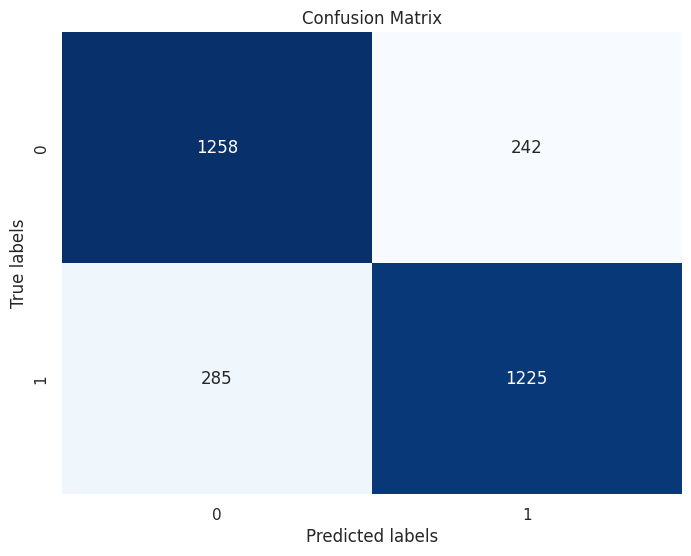

In [ ]:
# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, ypred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import joblib

# saving the model
model_file = '/content/drive/MyDrive/rbf_c1_g01.joblib'
joblib.dump(model, model_file)

###Poly SVM with Grid Search

In [ ]:
# Hyperparameter tuning for SVM with RBF kernel
param_grid = {'svc__C': [1, 5, 10],
              'svc__gamma': [0.0005, 0.001, 0.005]}
pca = PCA(n_components=150, whiten=True, random_state=42)
svm = SVC(kernel='poly', class_weight='balanced')
model = make_pipeline(pca, svm)
grid = GridSearchCV(model, param_grid, verbose=2)
%time grid.fit(X_train_reshaped, y_train)
print(f'Best parameters are: {grid.best_params_}')
mean_score = grid.cv_results_['mean_test_score']
std_score = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, std, params in zip(mean_score, std_score, params):
    print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')
model = grid.best_estimator_
ypred = model.predict(X_test_reshaped)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.1min
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.1min
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.1min
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.1min
[CV] END ........................svc__C=1, svc__gamma=0.0005; total time= 1.2min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.2min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.2min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.1min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.3min
[CV] END .........................svc__C=1, svc__gamma=0.001; total time= 1.2min
[CV] END .........................svc__C=1, svc__gamma=0.005; total time= 1.2min
[CV] END .........................svc__C=1, svc__

**Best parameter is: svc__C= 10, with degree= 3**

In [ ]:
# Accuracy and F1 scores for SVM with best Poly kernel
bestPoly_accuracy = accuracy_score(y_test, ypred)
bestPoly_f1 = f1_score(y_test, ypred, average='weighted')
print('Accuracy (Best Poly Kernel): ', "%.2f" % (bestPoly_accuracy*100))
print('F1 (Best Poly Kernel): ', "%.2f" % (bestPoly_f1*100))

Accuracy (Best Poly Kernel):  74.78
F1 (Best Poly Kernel):  73.93


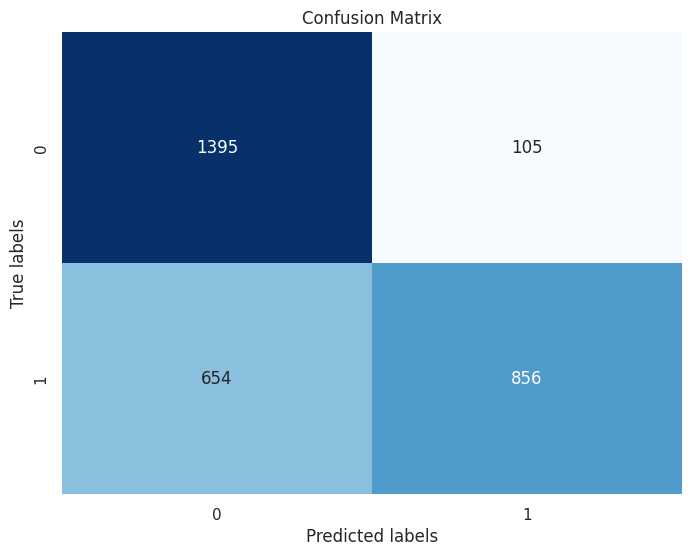

In [ ]:
# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, ypred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# saving the model
model_file = '/content/drive/MyDrive/poly_c1_g01.joblib'
joblib.dump(model, model_file)

['/content/drive/MyDrive/poly_c1_g01.joblib']

###Linear SVM with Grid Search

In [ ]:
# Hyperparameter tuning for SVM with Linear kernel
param_grid = {'svc__C': [0.005, 1, 5, 10]}
pca = PCA(n_components=150, whiten=True, random_state=42)
svm = SVC(kernel='linear', class_weight='balanced')
model = make_pipeline(pca, svm)
grid = GridSearchCV(model, param_grid, verbose=2)
%time grid.fit(X_train_reshaped, y_train)
print(f'Best parameters are: {grid.best_params_}')
mean_score = grid.cv_results_['mean_test_score']
std_score = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, std, params in zip(mean_score, std_score, params):
    print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')
model = grid.best_estimator_
ypred = model.predict(X_test_reshaped)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................................svc__C=0.005; total time= 1.0min
[CV] END .......................................svc__C=0.005; total time=  53.9s
[CV] END .......................................svc__C=0.005; total time=  54.1s
[CV] END .......................................svc__C=0.005; total time=  53.3s
[CV] END .......................................svc__C=0.005; total time=  53.5s
[CV] END ...........................................svc__C=1; total time= 1.1min
[CV] END ...........................................svc__C=1; total time= 1.1min
[CV] END ...........................................svc__C=1; total time= 1.2min
[CV] END ...........................................svc__C=1; total time= 1.1min
[CV] END ...........................................svc__C=1; total time= 1.1min
[CV] END ...........................................svc__C=5; total time= 2.0min
[CV] END ........................................

**Best parameter is: svc__C= 10**

Accuracy (Best Linear Kernel):  78.9

F1 (Best Linear Kernel):  78.4

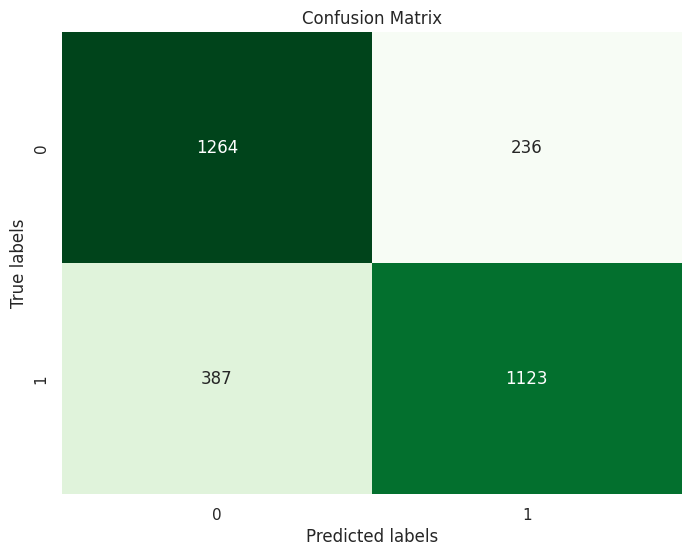

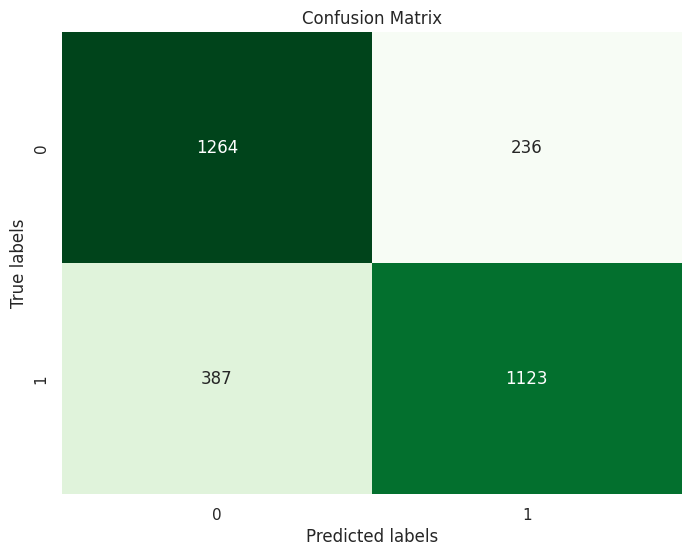

In [ ]:
# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, ypred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Ensemble Learning

## Random Forest

we will try different configurations of a Random Forest model to find the most effective setup for the given data, optimizes it, and assesses its final performance

### 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 30

In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [30],
    'max_depth': [6, 7],
    'min_samples_split': [8, 9],
    'min_samples_leaf': [3, 4]
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=4, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search_rf.fit(X_train, Y_train)

# Best parameters and best score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for Random Forest: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 30}
Best score for Random Forest: 0.8159989926336643


After identifying the best parameters through GridSearchCV, we wll use these parameters to train the model.

In [ ]:
best_params = {
    'max_depth': 7,
    'min_samples_leaf': 4,
    'min_samples_split': 8,
    'n_estimators': 30
}

best_rf_model = RandomForestClassifier(random_state=42,
                                       max_depth=best_params['max_depth'],
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       min_samples_split=best_params['min_samples_split'],
                                       n_estimators=best_params['n_estimators'])

# Fit the model with the best parameters to the training data
best_rf_model.fit(X_train, Y_train)

# Saving the model
model_file = '/content/drive/MyDrive/RandomForest82.joblib'
joblib.dump(best_rf_model, model_file)

y_pred = best_rf_model.predict(X_test)

In [ ]:
# Print Classification Report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       Paper       0.82      0.84      0.83      1537
     Plastic       0.83      0.81      0.82      1463

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



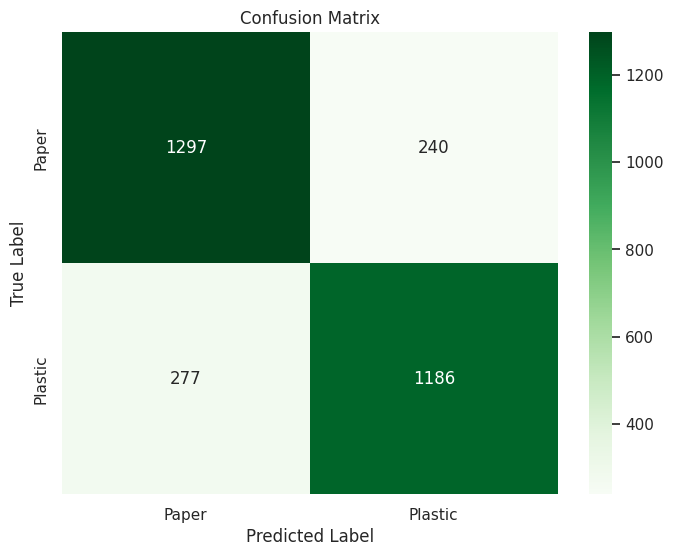

In [ ]:
# Calculate and plot the Confusion Matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens',
            xticklabels=['Paper', 'Plastic'],
            yticklabels=['Paper', 'Plastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

here we will train the Random Forest classifier using GridSearchCV to optimize its hyperparameters

### 'max_depth': 20, 'n_estimators': 300

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
}
rf_classifier = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5,n_jobs=4)
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

Best Hyperparameters:
{'max_depth': 20, 'n_estimators': 300}


In [ ]:
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)

Fthe optimized model is used to predict outcomes on a separate test dataset (X_test). This allows us to evaluate how well the model performs on new, unseen data

In [ ]:
best_rf_classifier.fit(X_train, Y_train)
y_pred = best_rf_classifier.predict(X_test)

In [ ]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       Paper       0.86      0.82      0.84      1546
     Plastic       0.82      0.86      0.84      1463

    accuracy                           0.84      3009
   macro avg       0.84      0.84      0.84      3009
weighted avg       0.84      0.84      0.84      3009



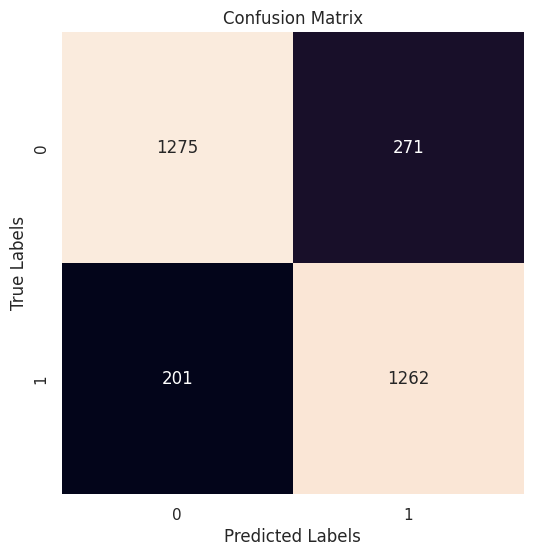

In [ ]:
# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get the top 10 results
results = grid_search.cv_results_
top_results_indices = results['mean_test_score'].argsort()[-10:][::-1]
top_results = [results['mean_test_score'][i] for i in top_results_indices]
top_params = [results['params'][i] for i in top_results_indices]

# Print the top 10 accuracy, precision, and recall results
print("Top 10 Evaluation Results:")
for score, params in zip(top_results, top_params):
    print(f"Accuracy: {score:.4f} | Parameters: {params}")

Top 10 Evaluation Results:
Accuracy: 0.8416 | Parameters: {'max_depth': 20, 'n_estimators': 300}
Accuracy: 0.8409 | Parameters: {'max_depth': 15, 'n_estimators': 300}
Accuracy: 0.8397 | Parameters: {'max_depth': 15, 'n_estimators': 200}
Accuracy: 0.8384 | Parameters: {'max_depth': 20, 'n_estimators': 200}
Accuracy: 0.8383 | Parameters: {'max_depth': 15, 'n_estimators': 100}
Accuracy: 0.8380 | Parameters: {'max_depth': 10, 'n_estimators': 300}
Accuracy: 0.8376 | Parameters: {'max_depth': 10, 'n_estimators': 200}
Accuracy: 0.8366 | Parameters: {'max_depth': 20, 'n_estimators': 100}
Accuracy: 0.8316 | Parameters: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.8144 | Parameters: {'max_depth': 5, 'n_estimators': 300}


In [ ]:
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8431372549019608


### 'max_depth': 30, 'n_estimators': 400

here we want to focus on fine-tuning the model's hyperparameters based on initial findings to achieve the best possible accuracy.

In [ ]:
# Fine-tuning the grid around the best found parameters
param_grid_refined = {
    'n_estimators': [300, 400, 500],
    'max_depth': [20, 25, 30],

}

rf_classifier = RandomForestClassifier(random_state=42)

# Creating a new grid search with refined parameters
grid_search_refined = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_refined, cv=5, n_jobs=4)
grid_search_refined.fit(X_train, Y_train)

# Print the best hyperparameters from the refined search
print("Best Hyperparameters from Refined Search:")
print(grid_search_refined.best_params_)

# Check the top results again
results_refined = grid_search_refined.cv_results_
top_results_indices_refined = results_refined['mean_test_score'].argsort()[-10:][::-1]
top_results_refined = [results_refined['mean_test_score'][i] for i in top_results_indices_refined]
top_params_refined = [results_refined['params'][i] for i in top_results_indices_refined]

print("Top 10 Refined Evaluation Results:")
for score, params in zip(top_results_refined, top_params_refined):
    print(f"Accuracy: {score:.4f} | Parameters: {params}")


Best Hyperparameters from Refined Search:
{'max_depth': 30, 'n_estimators': 400}
Top 10 Refined Evaluation Results:
Accuracy: 0.8433 | Parameters: {'max_depth': 30, 'n_estimators': 400}
Accuracy: 0.8429 | Parameters: {'max_depth': 20, 'n_estimators': 500}
Accuracy: 0.8429 | Parameters: {'max_depth': 30, 'n_estimators': 500}
Accuracy: 0.8429 | Parameters: {'max_depth': 30, 'n_estimators': 300}
Accuracy: 0.8427 | Parameters: {'max_depth': 25, 'n_estimators': 500}
Accuracy: 0.8419 | Parameters: {'max_depth': 25, 'n_estimators': 400}
Accuracy: 0.8417 | Parameters: {'max_depth': 20, 'n_estimators': 400}
Accuracy: 0.8416 | Parameters: {'max_depth': 25, 'n_estimators': 300}
Accuracy: 0.8416 | Parameters: {'max_depth': 20, 'n_estimators': 300}


In [ ]:
best_rf_classifier = grid_search_refined.best_estimator_

# Fit the best RandomForest model from the refined search
best_rf_classifier.fit(X_train, Y_train)

# Predict on test data
y_pred = best_rf_classifier.predict(X_test)

In [ ]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       Paper       0.96      0.95      0.95      1537
     Plastic       0.95      0.96      0.95      1463

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



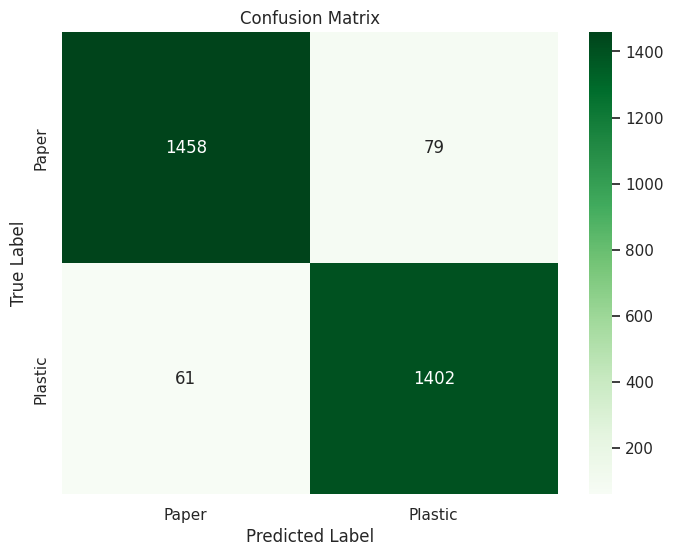

In [ ]:
# Calculate and plot the Confusion Matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens',
            xticklabels=['Paper', 'Plastic'],
            yticklabels=['Paper', 'Plastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate the model performance specifying 'average' parameter
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')
f1 = f1_score(Y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Model Performance Evaluation:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Model Performance Evaluation:
Accuracy : 0.9533
Precision: 0.9534
Recall   : 0.9533
F1 Score : 0.9533


In [ ]:
model_file = '/content/drive/MyDrive/RandomForest_model.joblib'
joblib.dump(best_rf_classifier, model_file)

['/content/drive/MyDrive/RandomForest_model.joblib']

## Gradient Boosting

below is the  process of configuring, training, and evaluating a Gradient Boosting classifier using GridSearchCV to optimize its hyperparameters.

learning_rate parameter is used here  (rate at which each additional tree influences the overall prediction)

GridSearchCV is configured with the Gradient Boosting model as the estimator, using the defined parameter grid, and accuracy as the scoring metric. This configuration allows for exhaustive search over the specified parameter grid to find the best combination based on model accuracy.

'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20

In [ ]:
# Parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [20],
    'learning_rate': np.linspace(0.05, 0.2, 4),
    'max_depth': [2],
    'min_samples_split': [10],
    'min_samples_leaf': [5]
}

# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb,
                              cv=3, n_jobs=4, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search_gb.fit(X_train, Y_train)

# Print the best parameters and the best score
print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)
print("Best score for Gradient Boosting:", grid_search_gb.best_score_)

*Fitting 3 folds for each of 4 candidates, totalling 12 fits*

*Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}*

*Best score for Gradient Boosting: 0.786285113811705*

In [ ]:
best_params = {
    'learning_rate': 0.2,
    'max_depth': 2,
    'min_samples_leaf': 5,
    'min_samples_split': 10,
    'n_estimators': 20
}

best_gb_model = GradientBoostingClassifier(random_state=42,
                                       learning_rate=best_params['learning_rate'],
                                       max_depth=best_params['max_depth'],
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       min_samples_split=best_params['min_samples_split'],
                                       n_estimators=best_params['n_estimators'])

# Fit the model with the best parameters to the training data
best_gb_model.fit(X_train, Y_train)

# Saving the model
model_file_gb = '/content/drive/MyDrive/GradientBoosting79.joblib'
joblib.dump(best_gb_model, model_file_gb)

y_pred = best_gb_model.predict(X_test)

In [ ]:
# Print Classification Report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       Paper       0.79      0.78      0.78      1537
     Plastic       0.77      0.78      0.77      1463

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



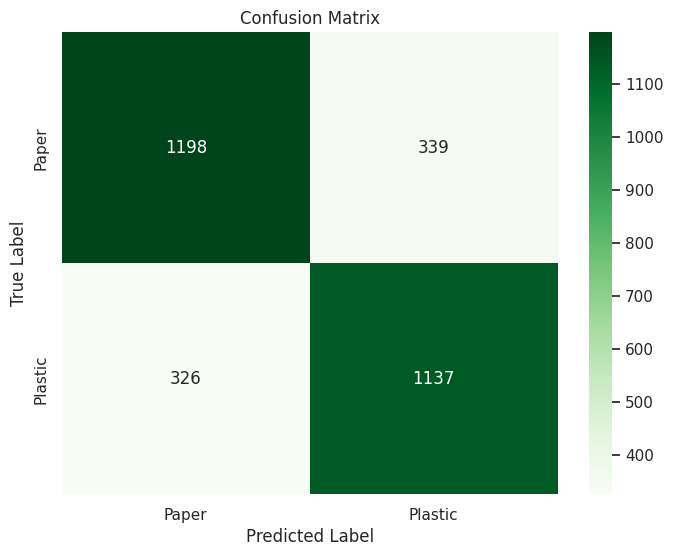

In [ ]:
# Calculate and plot the Confusion Matrix
model = joblib.load('/content/drive/MyDrive/uni/ML/GradientBoosting79.joblib')
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens',
            xticklabels=['Paper', 'Plastic'],
            yticklabels=['Paper', 'Plastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

the Gradient Boosting model shows a fairly balanced performance in classifying paper and plastic bags with an overall accuracy close to 78%.

# CNN Modles

## ResNet50

In the ResNet 50 The dataset is divided into training and test sets using a 80/20 split. This separation helps in training the model on a majority of the data while reserving a portion for final evaluation.

In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_df.shape

(8000, 2)

In [ ]:
test_df.shape

(2000, 2)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

To manage the training process effectively, the images are processed in batches of 32 , and each image is resized to 300x300 pixels. These settings ensure that the model receives data in consistent sizes and manageable numbers

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
print(train_images.classes[0:10])

[1, 0, 1, 0, 0, 0, 0, 1, 1, 0]


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
])

 A pre-trained ResNet50 model is loaded with weights from ImageNet, configured to exclude the top (fully connected layer), and include average pooling.

In [ ]:
#Loading pretrained model
pretrained_model=tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

 New layers are added on top of ResNet50 to adapt the model to the specific classification task. This includes a resizing and rescaling layer, dense layers with ReLU activation and dropout for regularization, and a final dense layer with softmax activation for classification.

In [ ]:
inputs = pretrained_model.inputs

x = resize_and_rescale(inputs)
x = Dense(256,activation='relu')(pretrained_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(2, activation='softmax')(x)

In [ ]:
model = Model(inputs,outputs)

The model is compiled with the Adam optimizer, using a learning rate of 0.0001, and it's set to minimize categorical crossentropy loss, tracking accuracy as the performance metric.

In [ ]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        tensorboard_callback,
        checkpoint_callback,
    ]
)

Epoch 1/10
200/200 [==============================] - 430s 2s/step - loss: 0.3459 - accuracy: 0.8445 - val_loss: 0.0915 - val_accuracy: 0.9681
Epoch 2/10
200/200 [==============================] - 454s 2s/step - loss: 0.1258 - accuracy: 0.9520 - val_loss: 0.0861 - val_accuracy: 0.9688
Epoch 3/10
200/200 [==============================] - 416s 2s/step - loss: 0.0855 - accuracy: 0.9680 - val_loss: 0.0605 - val_accuracy: 0.9762
Epoch 4/10
200/200 [==============================] - 416s 2s/step - loss: 0.0614 - accuracy: 0.9778 - val_loss: 0.0479 - val_accuracy: 0.9831
Epoch 5/10
200/200 [==============================] - 477s 2s/step - loss: 0.0502 - accuracy: 0.9812 - val_loss: 0.0457 - val_accuracy: 0.9819
Epoch 6/10
200/200 [==============================] - 413s 2s/step - loss: 0.0363 - accuracy: 0.9878 - val_loss: 0.0480 - val_accuracy: 0.9819
Epoch 7/10
200/200 [==============================] - 416s 2s/step - loss: 0.0351 - accuracy: 0.9884 - val_loss: 0.0405 - val_accuracy: 0.9856

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02106
Test Accuracy: 99.15%


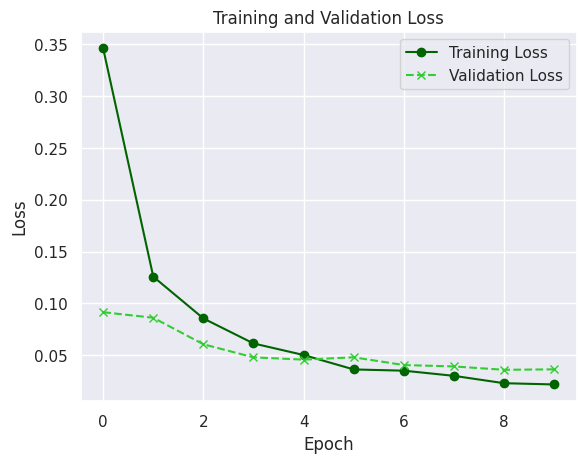

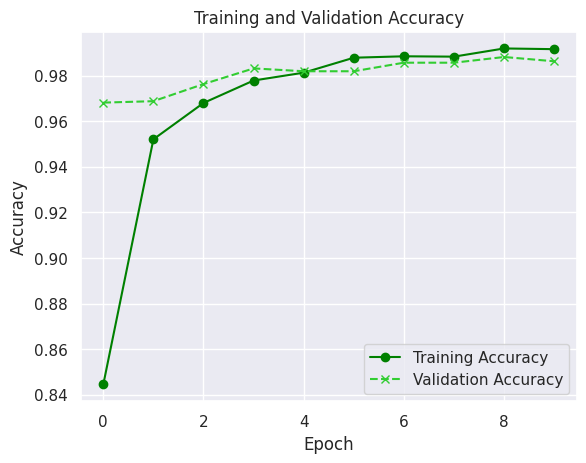

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(history.history['loss'], label='Training Loss', color='darkgreen', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='limegreen', linestyle='--', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='limegreen', linestyle='--', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The graphs indicate a well-performing model with high accuracy and low loss.

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

63/63 [==============================] - 113s 2s/step
The first 10 predictions: ['Plastic', 'Paper', 'Paper', 'Paper', 'Paper', 'Plastic', 'Paper', 'Plastic', 'Plastic', 'Paper']


In [ ]:
# Add the Label column to test_df
test_df = test_df.iloc[:len(pred)].copy()
test_df.loc[:, 'Label'] = pred

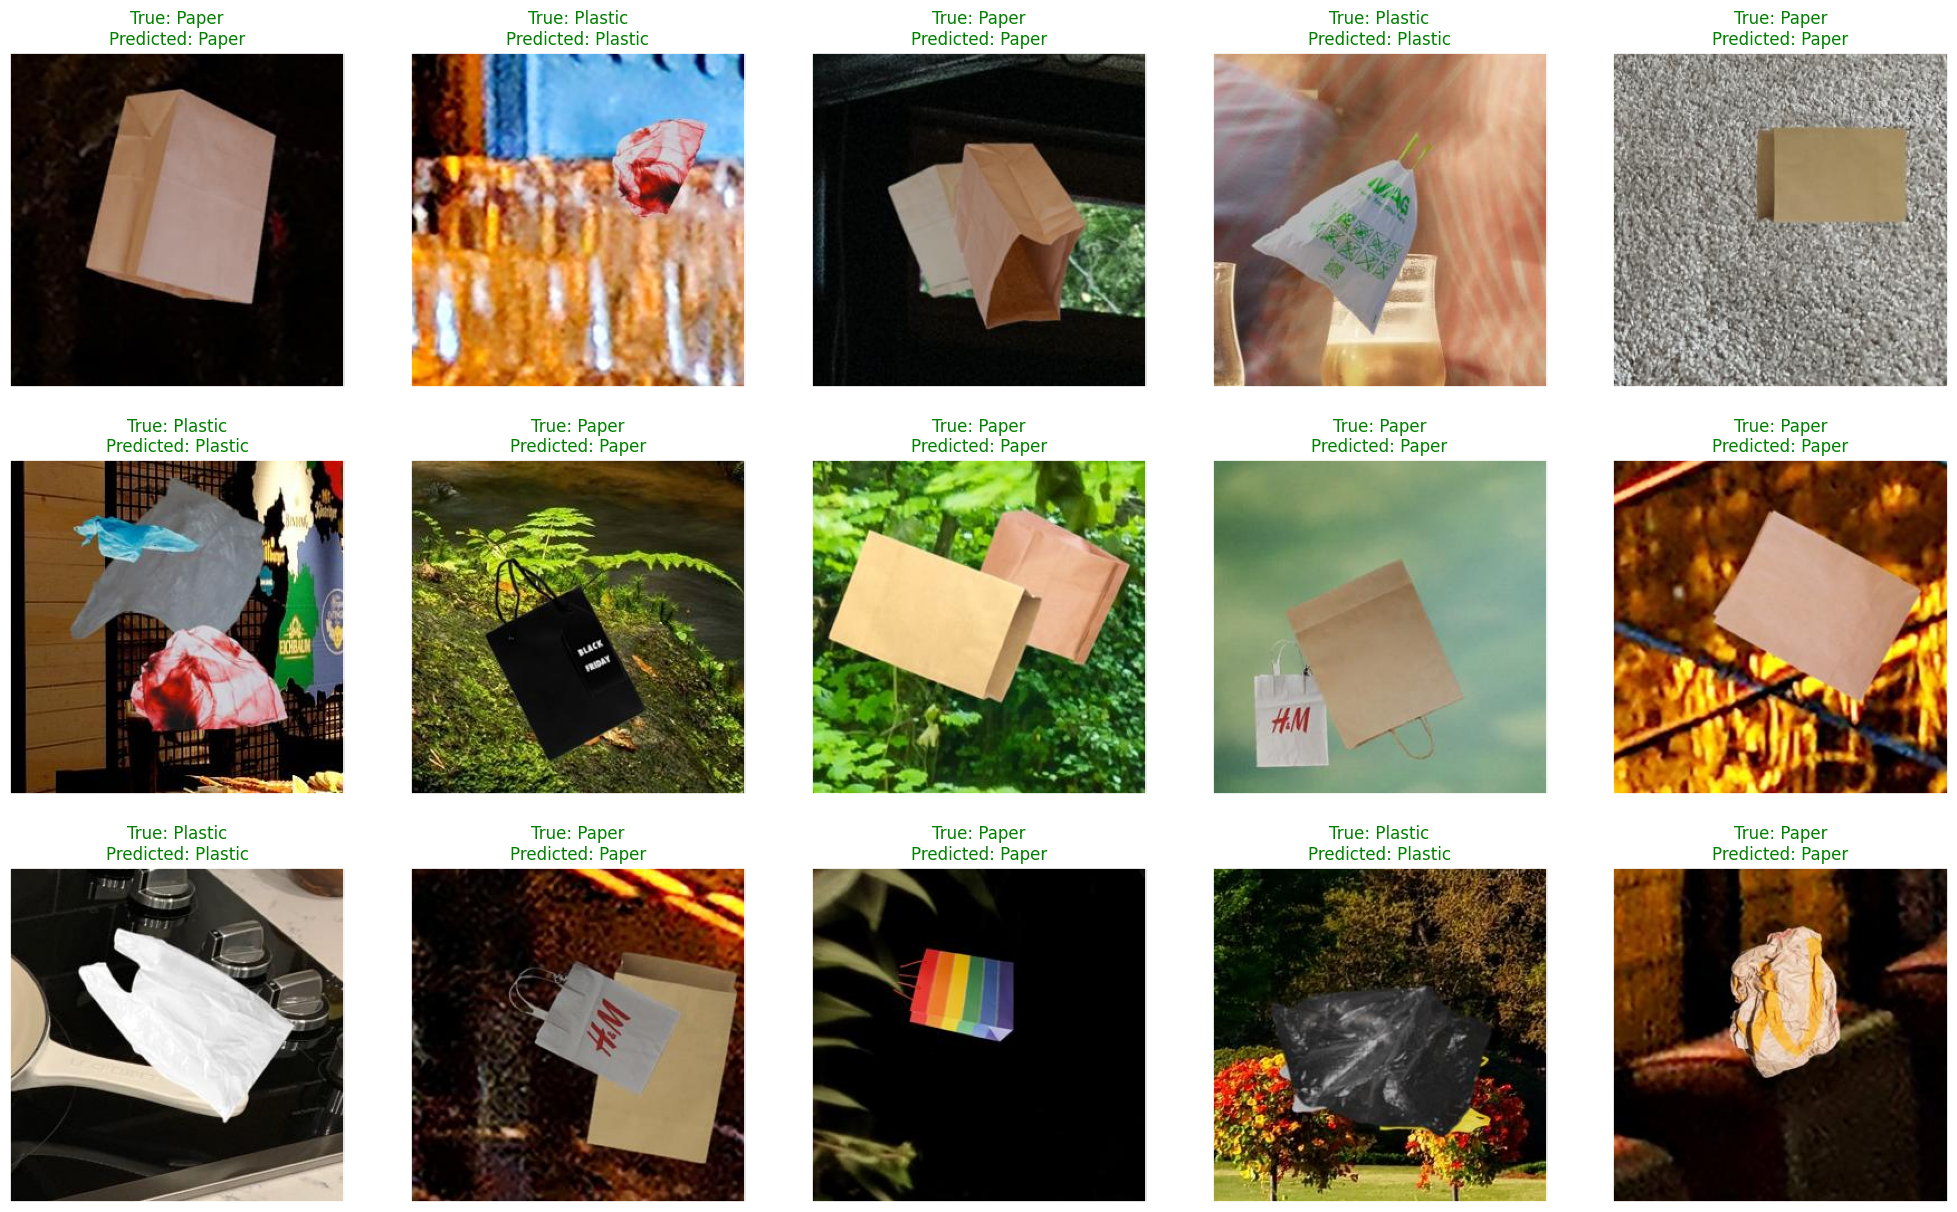

<Figure size 640x480 with 0 Axes>

In [ ]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

This is a test sample shows how accurate the model is

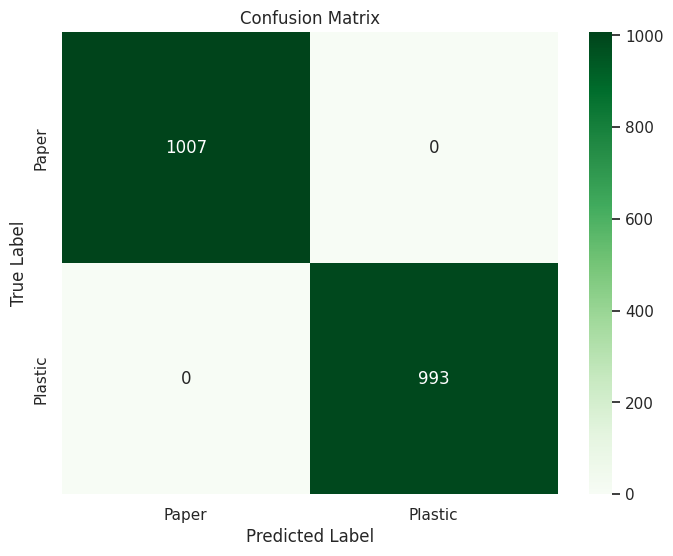

In [ ]:
# Calculate and plot the Confusion Matrix
conf_matrix = confusion_matrix(test_df['Label'], pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens',
            xticklabels=['Paper', 'Plastic'],
            yticklabels=['Paper', 'Plastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate classification report
print("Classification Report:")
print(classification_report(test_df['Label'], pred))

Classification Report:
              precision    recall  f1-score   support

       Paper       1.00      1.00      1.00      1007
     Plastic       1.00      1.00      1.00       993

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
# Save the ResNet50 model
resnet_model_path = "/content/drive/MyDrive/resnet_model.h5"
pretrained_model.save(resnet_model_path)

print("ResNet50 model saved successfully at:", resnet_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


ResNet50 model saved successfully at: /content/drive/MyDrive/resnet_model.h5


## ResNet50V2

At the Resnet50V2 The dataset is split into training (80%) and testing (20%) sets, ensuring a good distribution of data for both training and performance evaluation.

In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_df.shape

(8000, 2)

In [ ]:
test_df.shape

(2000, 2)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

The generators prepare batches of images batch size 32, resizing them to 224x224 pixels, and applying real-time data augmentation for the training set. This process enhances model generalization by introducing variability in the training data.


In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


Additional layers are added to the pretrained base: a resize and rescale layer, two dense layers with ReLU activation and dropout for regularization, and a final softmax layer for binary classification (two classes).

In [ ]:
# Extract true labels for test data
test_labels = test_images.classes
labels = dict((v, k) for k, v in train_images.class_indices.items())
y_test = [labels[i] for i in test_labels]

In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Loading pretrained ResNet50V2 model
pretrained_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

In [ ]:
inputs = pretrained_model.inputs
x = resize_and_rescale(inputs)
x = Dense(256,activation='relu')(pretrained_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(2, activation='softmax')(x)

In [ ]:
model = Model(inputs,outputs)

In [ ]:
model.compile(
    optimizer = Adam(0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        tensorboard_callback,
        checkpoint_callback,
    ]
)

Epoch 1/10
200/200 [==============================] - 1133s 6s/step - loss: 0.3588 - accuracy: 0.8483 - val_loss: 0.1153 - val_accuracy: 0.9581
Epoch 2/10
200/200 [==============================] - 30s 150ms/step - loss: 0.1704 - accuracy: 0.9347 - val_loss: 0.0877 - val_accuracy: 0.9638
Epoch 3/10
200/200 [==============================] - 30s 150ms/step - loss: 0.1261 - accuracy: 0.9534 - val_loss: 0.0816 - val_accuracy: 0.9675
Epoch 4/10
200/200 [==============================] - 29s 145ms/step - loss: 0.0979 - accuracy: 0.9611 - val_loss: 0.0673 - val_accuracy: 0.9737
Epoch 5/10
200/200 [==============================] - 29s 146ms/step - loss: 0.0777 - accuracy: 0.9719 - val_loss: 0.0626 - val_accuracy: 0.9750
Epoch 6/10
200/200 [==============================] - 29s 143ms/step - loss: 0.0714 - accuracy: 0.9727 - val_loss: 0.0596 - val_accuracy: 0.9781
Epoch 7/10
200/200 [==============================] - 29s 147ms/step - loss: 0.0568 - accuracy: 0.9780 - val_loss: 0.0614 - val_acc

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.04866
Test Accuracy: 98.10%


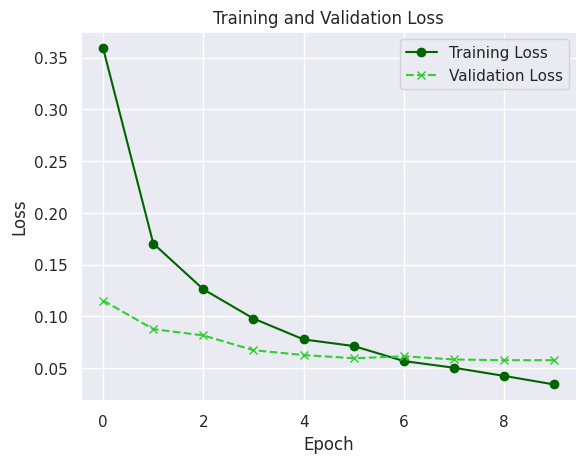

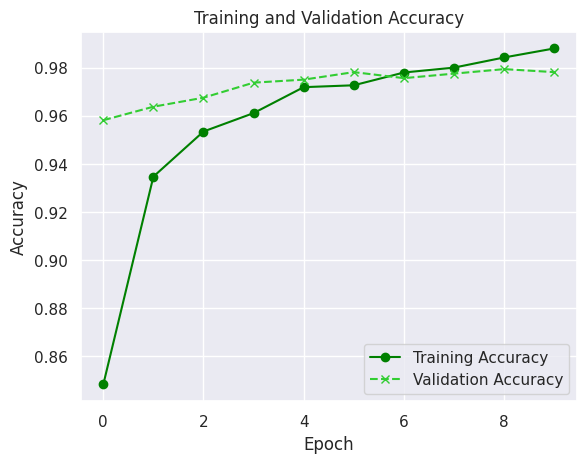

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(history.history['loss'], label='Training Loss', color='darkgreen', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='limegreen', linestyle='--', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='limegreen', linestyle='--', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test the model
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the predictions to the labels
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Save the trained model to Google Drive
model_path = "/content/drive/MyDrive/ResNet50V2.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

63/63 [==============================] - 8s 113ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/ResNet50V2.h5


The model predicts on the test set, and the predictions are converted from class indices back to actual labels.

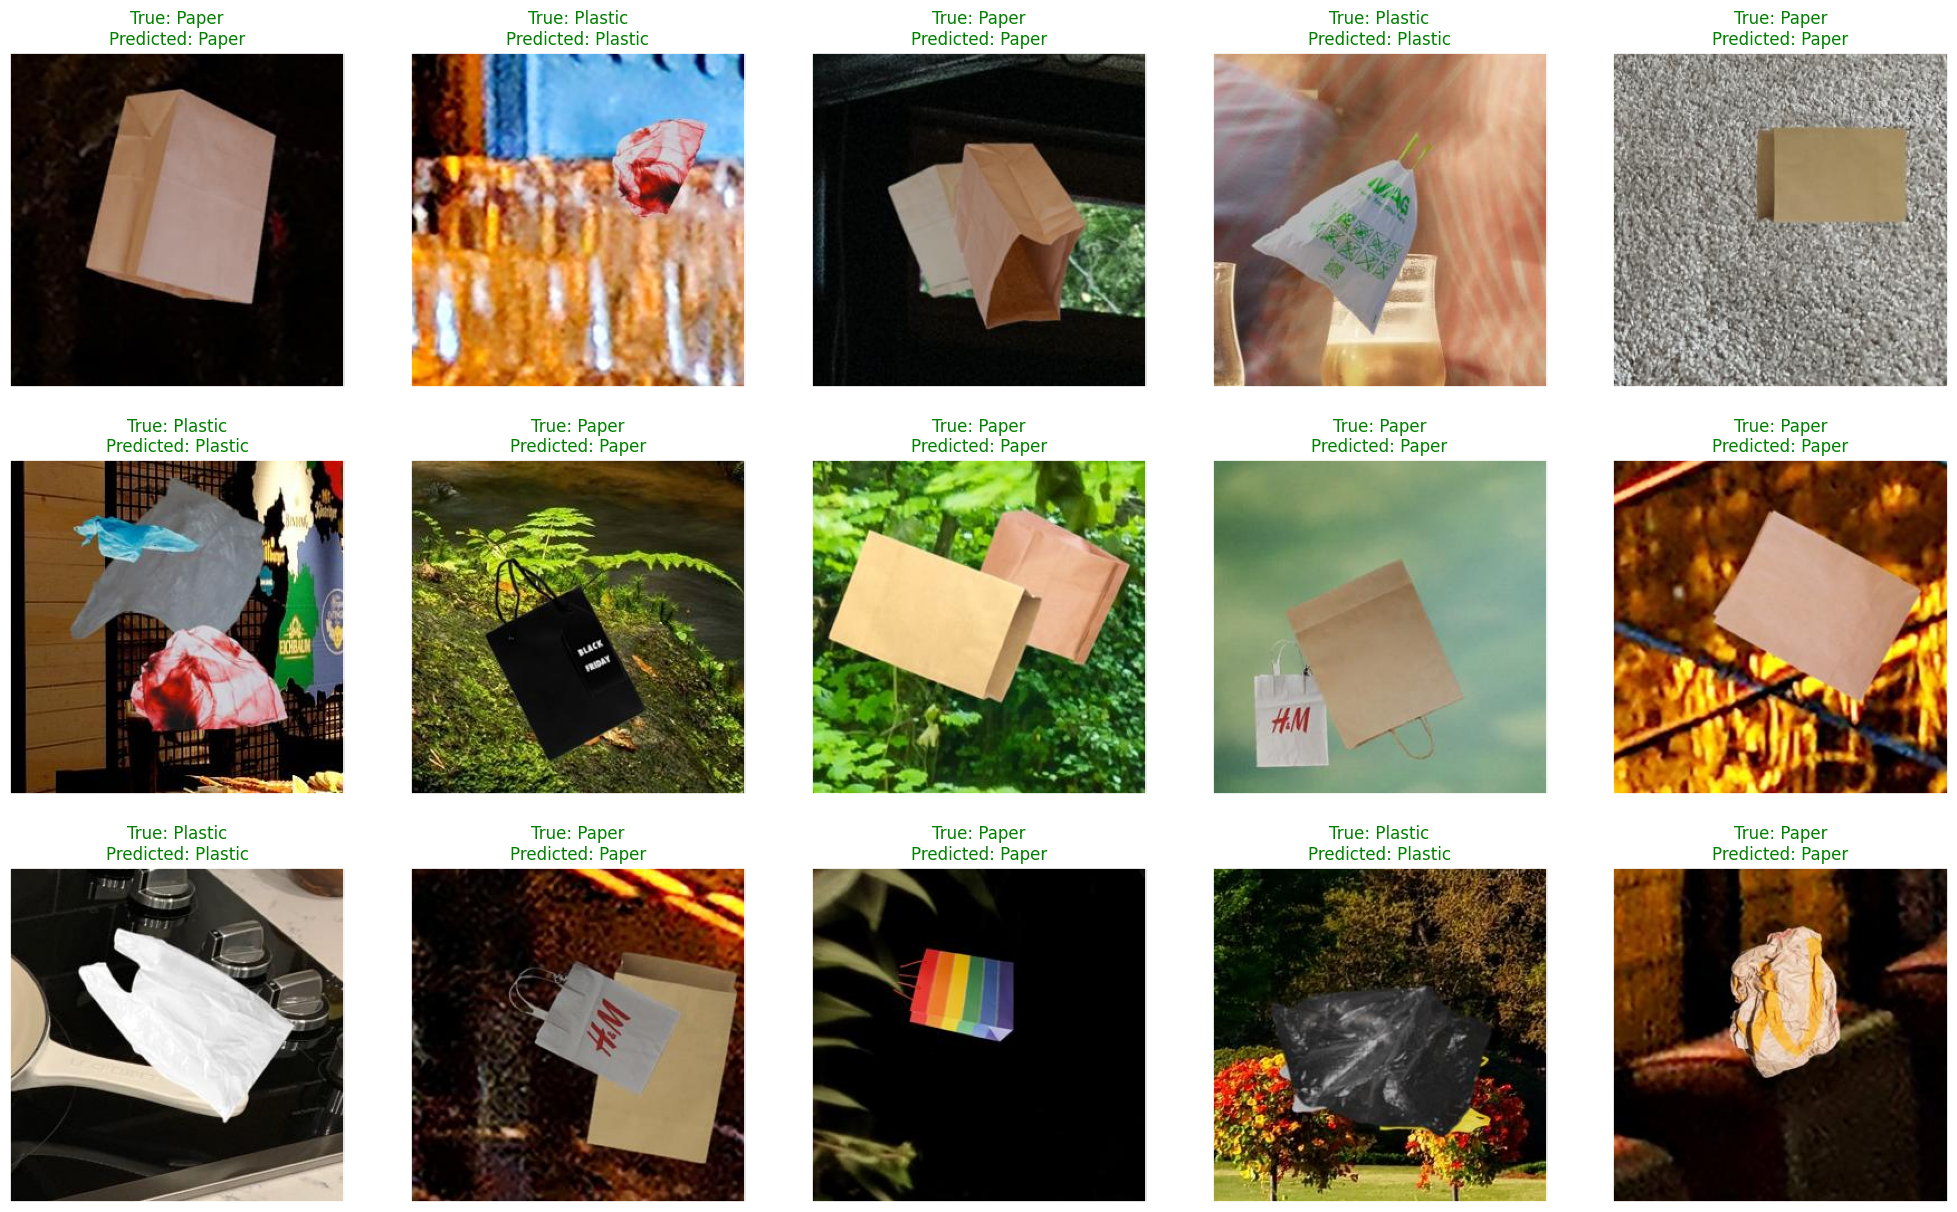

<Figure size 640x480 with 0 Axes>

In [ ]:
# Add the Label column to the test_df DataFrame
test_df = test_df.iloc[:len(pred)]
test_df['Label'] = pred

random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, pred))

Classification Report:
              precision    recall  f1-score   support

       Paper       0.97      0.99      0.98      1012
     Plastic       0.99      0.97      0.98       988

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



it has accuracy = 98 this indicates that ResNet50 and Resnet50v2 are considered one of the most powerful model architectures in the field of deep learning, particularly for image recognition tasks.

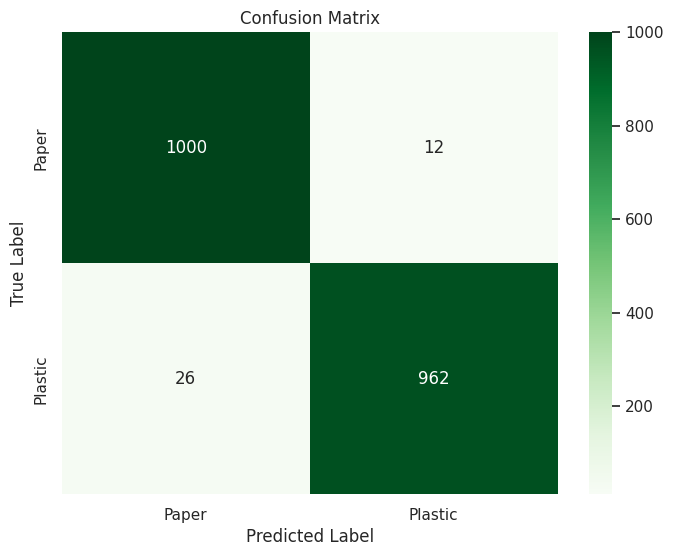

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens',
            xticklabels=['Paper', 'Plastic'],
            yticklabels=['Paper', 'Plastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## VGG16

The data is reshaped to fit the input requirements of image-based models, specifically (256, 256, 3), which denotes images of 256x256 pixels with 3 color channels (RGB).

The rescale=1./255 argument is a common practice for normalizing pixel values from [0, 255] to [0, 1]

batches of 32 imagesis a typical setting that balances memory usage and performance efficiency.

In [ ]:
# Reshape the input data to match the expected shape for ImageDataGenerator
X_train_reshaped = X_train.reshape(-1, 256, 256, 3)
X_test_reshaped = X_test.reshape(-1, 256, 256, 3)

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    X_train_reshaped,
    Y_train,
    batch_size=32
)

test_generator = test_datagen.flow(
    X_test_reshaped,
    Y_test,
    batch_size=32
)

A Dense layer with 256 units and ReLU activation function is added to introduce the capability to learn complex patterns from the flattened features.
A final Dense layer with one unit and a sigmoid activation function is added to output a binary prediction

In [ ]:
# Load the VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom dense layers on top of the VGG16 convolutional base
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model2 = Model(inputs=vgg_base.input, outputs=output)

# Freeze the weights of the VGG16 layers
for layer in vgg_base.layers:
    layer.trainable = False

# Compile the model
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the model architecture
model2.summary()

# Train the model
model2.fit(train_generator, epochs=10, validation_data=test_generator)

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                            

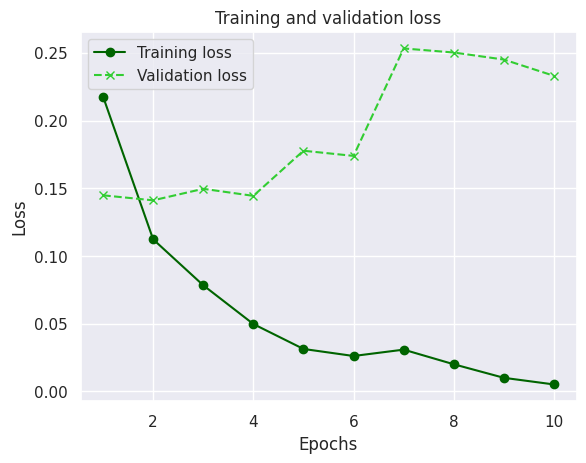

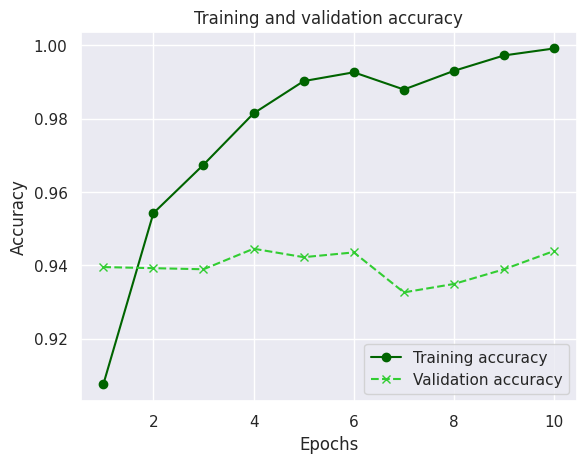

In [ ]:
# Manually add the training history values
training_loss = [0.2177, 0.1123, 0.0784, 0.0498, 0.0314, 0.0262, 0.0309, 0.0201, 0.0101, 0.0052]
validation_loss = [0.1448, 0.1411, 0.1496, 0.1444, 0.1777, 0.1739, 0.2532, 0.2502, 0.2450, 0.2330]
training_accuracy = [0.9075, 0.9542, 0.9674, 0.9814, 0.9902, 0.9926, 0.9879, 0.9930, 0.9972, 0.9991]
validation_accuracy = [0.9395, 0.9392, 0.9389, 0.9445, 0.9422, 0.9435, 0.9326, 0.9349, 0.9389, 0.9439]
epochs = range(1, len(training_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, training_loss, 'o-', label='Training loss', color='darkgreen')
plt.plot(epochs, validation_loss, 'x--', label='Validation loss', color='limegreen')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(epochs, training_accuracy, 'o-', label='Training accuracy', color='darkgreen')
plt.plot(epochs, validation_accuracy, 'x--', label='Validation accuracy', color='limegreen')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Get the predicted classes for the test set
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

# Get true classes from the test set generator
true_classes = test_generator.classes

95/95 [==============================] - 295s 3s/step - loss: 0.1597 - accuracy: 0.9439
Test Accuracy: 0.9438537955284119
95/95 [==============================] - 260s 3s/step


In [ ]:
# Save the entire model to a file
model2.save('my_vgg16_model.h5')  # Save to an HDF5 file

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
